In [1]:
# 0. 환경설정 -------------------------------------------------------
library(tm)
if (!require("tidytext")) {install.packages("tidytext")}
library(qdap)
if (!require("tidyverse")) {install.packages("tidyverse")}
library(wordcloud)
library(tibble)
library(plotrix)
library(stringr)

Loading required package: NLP
Loading required package: tidytext
Loading required package: qdapDictionaries
Loading required package: qdapRegex
Loading required package: qdapTools
Loading required package: RColorBrewer

Attaching package: ‘qdap’

The following objects are masked from ‘package:tm’:

    as.DocumentTermMatrix, as.TermDocumentMatrix

The following object is masked from ‘package:NLP’:

    ngrams

The following object is masked from ‘package:base’:

    Filter

Loading required package: tidyverse
─ Attaching packages ──────────────────── tidyverse 1.2.1 ─
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ ggplot2::%+%()      masks qdapRegex::%+%()
✖ ggplot2::annotate() masks NLP::annotate()
✖ dplyr::explain()    masks qdapRegex::explain()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::id()         masks qdapTools::id

### clean_text기능 (from qdap: Quantitative Discourse Analysis Package)
1. 소문자로 변환
2. 숫자를 단어로 바꿈(1 : One)
3. 약어를 풀어줌(OMG: oh my god)
4. 말줄임표를 풀어줌(it's : it is)
5. 기호를 바꿔줌(@: at)
6. 문장부호 생략
7. 공백문자 제거
8. 특정 문자열 임의변경

In [15]:
clean_text <- function(text){
  text <- tolower(text)
  # text <- removeNumbers(text)
  # text <- bracketX(text)
  text <- replace_number(text)
  text <- replace_abbreviation(text)
  text <- replace_contraction(text)
  text <- replace_symbol(text)
  text <- removePunctuation(text)
  text <- stripWhitespace(text)
  text <- str_replace_all(text, "americans", "america")
  
  indexes <- which(text == "")
  if(length(indexes) > 0){
    text <- text[-indexes]
  } 
  return(text)
}

### clean corpus기능(from tm: text mining)
1. r 오브젝트 내의 함수를 수정하는 기능(약어를 풀어서 말뭉치로 저장)
2. 공백제거
3. 문장부호제거
4. 숫자제거
5. stopwords제거
6. r 오브젝트 내의 함수를 수정하는 기능(소문자로 바꿔서 말뭉치로 저장)

In [16]:
clean_corpus <- function(corpus){
  corpus <- tm_map(corpus, content_transformer(replace_abbreviation))
  corpus <- tm_map(corpus, stripWhitespace)
  corpus <- tm_map(corpus, removePunctuation)
  corpus <- tm_map(corpus, removeNumbers)
  corpus <- tm_map(corpus, removeWords, c(stopwords("en"), "Top200Words"))
  corpus <- tm_map(corpus, content_transformer(tolower))
  return(corpus)
}

In [17]:
# 1. 데이터 불러오기 -------------------------------------------------------
obama <- readLines("obama.txt", encoding = "UTF-8")
trump <- readLines("trump.txt", encoding = "UTF-8")

### 말뭉치를 만드는 기능(from tm)
1. 텍스트 전처리
2. VectorSource라는 별도 제공 프레임에 텍스트를 넣음
3. VCorpus라는 별도 제공 프레임에 VectorSource화된 데이터를 넣음
4. 말뭉치 전처리

In [18]:
# 2. 데이터 전처리 -------------------------------------------------------
make_corpus <- function(text) {
  text_clean <- clean_text(text)
  text_source <- VectorSource(text_clean)
  text_corpus <- VCorpus(text_source)
  corpus <- clean_corpus(text_corpus)
}

obama_corpus <- make_corpus(obama)
trump_corpus <- make_corpus(trump)

### 말뭉치의 데이터 등장 횟수를 세는 기능
termdocumentmatrix: 문서당 단어가 몇 번 생성되었는지를 만들어주는 함수(오바마에 단어 몇개가 등장했는지/트럼프에 어떤 단어가 얼마나 등장했는지)
```R
%>% : 파이프 생성 예약어
동일한 작업을 한꺼번에 실행시켜주는 함수, 직전 함수의 값을 출력받아 다음 함수로 바로 넘겨준다.
```

In [19]:
# 3. 말뭉치를 데이터프레임으로 변환 --------------------------------------

word_freq <- function(corpus) {
    doc_tdm <- TermDocumentMatrix(corpus)
    doc_m <- as.matrix(doc_tdm)
    doc_term_freq <- rowSums(doc_m)
    doc_word_freqs <- data.frame(term = names(doc_term_freq),
                             num = doc_term_freq) %>% arrange(desc(num))
    return(doc_word_freqs)
}

obama_word_freqs <- word_freq(obama_corpus)
trump_word_freqs <- word_freq(trump_corpus)

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

In [28]:
head(obama_word_freqs)
head(trump_word_freqs)

term,num
will,30
america,23
just,21
democracy,20
can,16
people,15


term,num
will,40
america,20
american,12
country,9
people,9
one,8


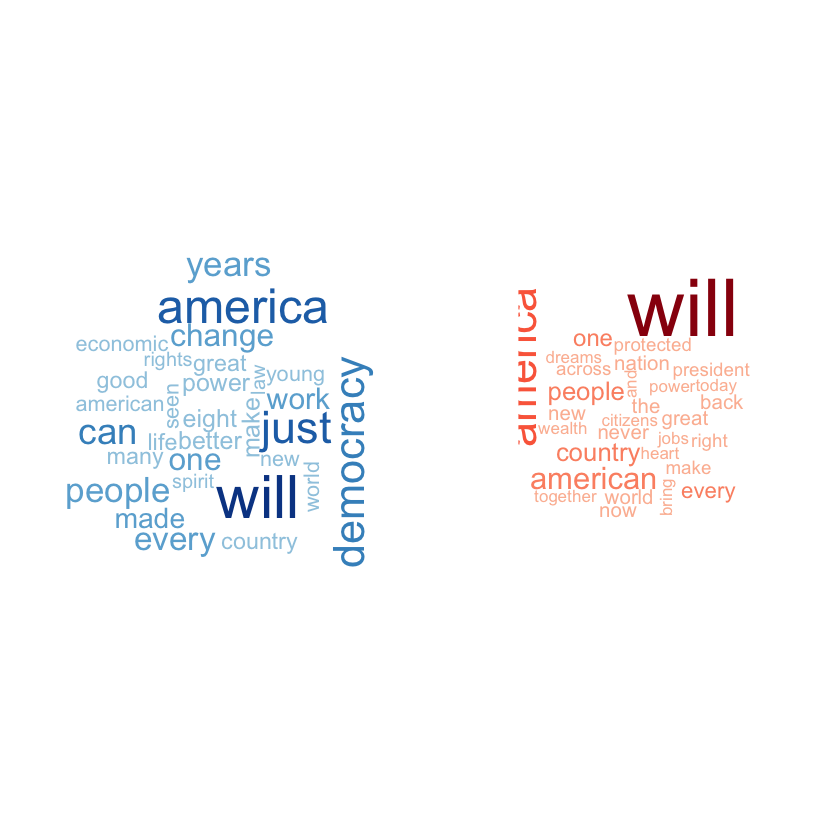

In [32]:
# 4. 시각화 --------------------------------------------------------------
## 4.1. 단어구름----------------------------------------------------------
par(mfrow=c(1,2))
blues <- brewer.pal(8, "Blues")[-(1:2)]
wordcloud(obama_word_freqs$term, obama_word_freqs$num, scale=c(3,0.5),max.words=30, colors=blues)

reds <- brewer.pal(8, "Reds")[-(1:2)]
wordcloud(trump_word_freqs$term, trump_word_freqs$num, scale=c(4,0.5),max.words=30, colors=reds)

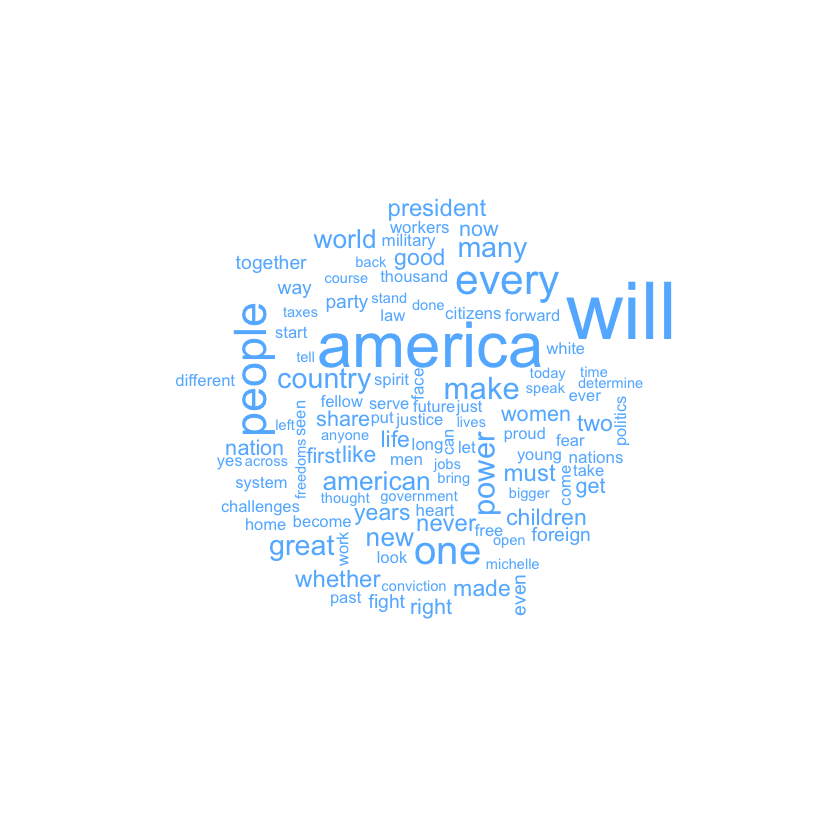

In [38]:
## 4.2. 공통 wordcloud
#모든 문장을 하나로 붙이기
all_obama <- paste(obama, collapse = " ")
all_trump <- paste(trump, collapse = " ")
#벡터 합치기
obama_trump <- c(all_obama, all_trump)
#전체로 코퍼스 만들고 frequency 만들기
obama_trump_corpus <- make_corpus(obama_trump)
obama_trump_word_freqs <- word_freq(obama_trump_corpus)

obama_trump_tdm <- TermDocumentMatrix(obama_trump_corpus)
obama_trump_m <- as.matrix(obama_trump_tdm)
#wordcloud기능 중 재미있는 기능 소개
commonality.cloud(obama_trump_m,  colors ="steelblue1", max.words=100)

,Obama,Trump
’ve,0,3
ability,2,0
abolitionists,1,0
accept,1,1
accepting,1,0
accountable,1,0


Warning message in strwidth(words[i], cex = size[i], ...):
“conversion failure on '’ve' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in strwidth(words[i], cex = size[i], ...):
“conversion failure on '’ve' in 'mbcsToSbcs': dot substituted for <80>”Warning message in strwidth(words[i], cex = size[i], ...):
“conversion failure on '’ve' in 'mbcsToSbcs': dot substituted for <99>”Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
“conversion failure on '’ve' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
“conversion failure on '’ve' in 'mbcsToSbcs': dot substituted for <80>”Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
“conversion failure on '’ve' in 'mbcsToSbcs': dot substituted for <99>”Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
“유니코드 문자 U+2019에 

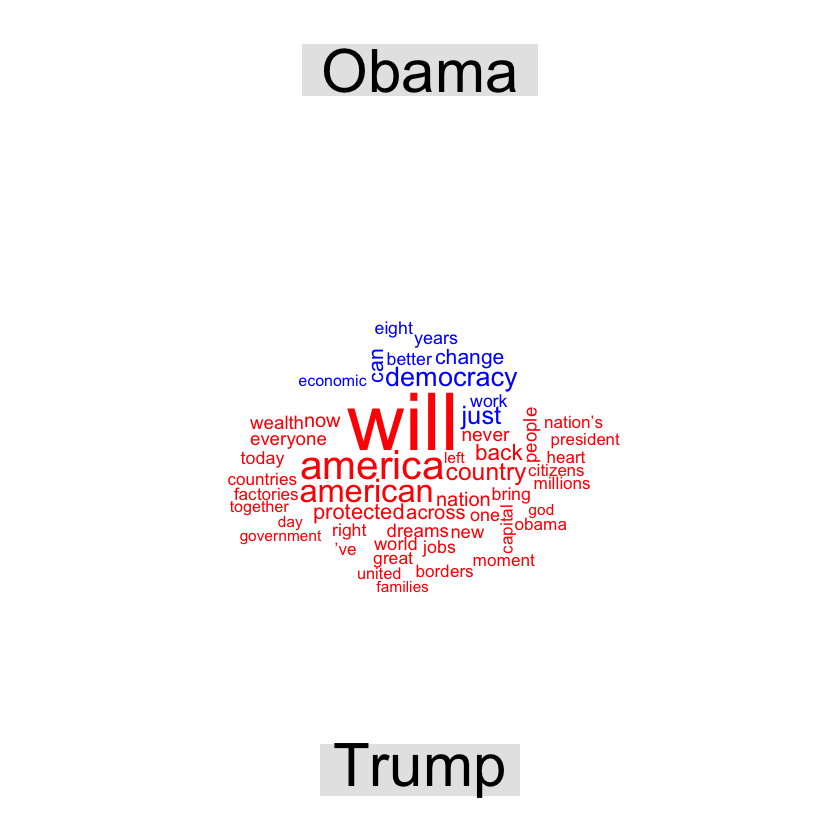

In [44]:
## 4.3. wordcloud comparison
colnames(obama_trump_tdm) <- c("Obama", "Trump")
obama_trump_df <- as.matrix(obama_trump_tdm) %>% as.data.frame()
head(obama_trump_df)
#wordcloud 기능 중 재미있는 기능 소개
comparison.cloud(obama_trump_df, colors = c("blue", "red"), max.words = 50)

| 함수명      | 내용                             | 유사함수        |
|-------------|----------------------------------|-----------------|
| filter()    | 지정한 조건식에 맞는 데이터 추출 | subset()        |
| select()    | 열의 추출                        | data[,c("")]    |
| mutate()    | 열 추가                          | transform()     |
| arrange()   | 정렬                             | order(), sort() |
| summerise() | 집계                             | aggregate()     |

In [48]:
## 4.4. 피라미드 그래프
#data manipulation, providing a consistent set of verbs dplyr
#reference : https://wsyang.com/2014/02/introduction-to-dplyr/
par(mfrow=c(1,1))

common_words_25 <- obama_trump_df %>% #오리지널 소스는 dataframe
  mutate(label = rownames(obama_trump_df)) %>% #
  dplyr::filter(Obama > 0 & Trump >0) %>% 
  mutate(diff = abs(Obama - Trump)) %>% 
  arrange(desc(diff)) %>% slice(1:25)
common_words_25

Obama,Trump,label,diff
21,1,just,20
16,1,can,15
15,2,years,13
12,1,work,11
30,40,will,10
11,2,made,9
14,7,every,7
8,2,good,6
8,2,life,6
15,9,people,6


[1] 5.1 4.1 4.1 2.1

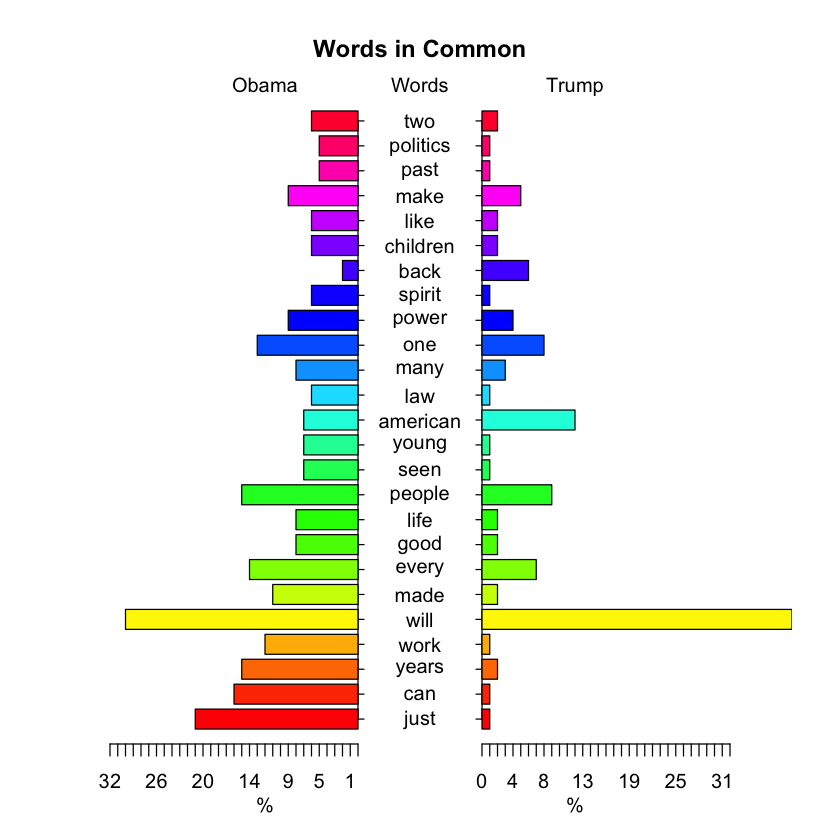

In [49]:
plotrix::pyramid.plot(common_words_25$Obama, common_words_25$Trump,
             labels = common_words_25$label, gap = 8,
             top.labels = c("Obama", "Words", "Trump"),
             main = "Words in Common")